In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.utils import compute_class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import F1Score

sns.set_theme(style='whitegrid', palette='dark')

# Data Preprocessing

**Outline of Section Contents**

The following section contains initial loading and preprocessing steps conducted. These steps included displaying the dataset structure and distributions of numerical features to get an idea of how the dataset was laid out. Missing values and duplicate entries were also screened for to prevent issues with later analyses. One initial feature engineering step was taken. This was the removing of the employee number feature column as it would provide no analytical value due to being a unique identifier.

Whilst categorised as part of preprocessing, the bulk of the feature engineering was included as a subsection of the exploratory data analysis section. This was to allow for easier interpretability of the visuals generated in that section through the use of full column values for categorical features rather than encoding said features and requiring the user to refer repeatedly to a legend.

In [2]:
# Loading the INX Employee Performance Dataset
data = pd.read_excel("INX_Future_Inc_Employee_Performance_CDS_Project2_Data_V1.8.xls")

In [3]:
# Displaying the First Few Rows of the Dataset
data.head()

,EmpNumber,Age,Gender,EducationBackground,MaritalStatus,EmpDepartment,EmpJobRole,BusinessTravelFrequency,DistanceFromHome,EmpEducationLevel,...,EmpRelationshipSatisfaction,TotalWorkExperienceInYears,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,PerformanceRating
0,E1001000,32,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,10,3,...,4,10,2,2,10,7,0,8,No,3
1,E1001006,47,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,14,4,...,4,20,2,3,7,7,1,7,No,3
2,E1001007,40,Male,Life Sciences,Married,Sales,Sales Executive,Travel_Frequently,5,4,...,3,20,2,3,18,13,1,12,No,4
3,E1001009,41,Male,Human Resources,Divorced,Human Resources,Manager,Travel_Rarely,10,4,...,2,23,2,2,21,6,12,6,No,3
4,E1001010,60,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,16,4,...,4,10,1,3,2,2,2,2,No,3


In [4]:
#Getting an idea of the columns and datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   EmpNumber                     1200 non-null   object
 1   Age                           1200 non-null   int64 
 2   Gender                        1200 non-null   object
 3   EducationBackground           1200 non-null   object
 4   MaritalStatus                 1200 non-null   object
 5   EmpDepartment                 1200 non-null   object
 6   EmpJobRole                    1200 non-null   object
 7   BusinessTravelFrequency       1200 non-null   object
 8   DistanceFromHome              1200 non-null   int64 
 9   EmpEducationLevel             1200 non-null   int64 
 10  EmpEnvironmentSatisfaction    1200 non-null   int64 
 11  EmpHourlyRate                 1200 non-null   int64 
 12  EmpJobInvolvement             1200 non-null   int64 
 13  EmpJobLevel       

**Comments on Dataset Strucuture**

The datasets is comprised of a mixture of numerical and categorical data. Based on the second sheet of the Excel document containing the dataset, ome of the numerical columns represent categorical data that has already been encoded using label encoding.

In [5]:
# Checking for Missing Values
data.isnull().sum()

EmpNumber                       0
Age                             0
Gender                          0
EducationBackground             0
MaritalStatus                   0
EmpDepartment                   0
EmpJobRole                      0
BusinessTravelFrequency         0
DistanceFromHome                0
EmpEducationLevel               0
EmpEnvironmentSatisfaction      0
EmpHourlyRate                   0
EmpJobInvolvement               0
EmpJobLevel                     0
EmpJobSatisfaction              0
NumCompaniesWorked              0
OverTime                        0
EmpLastSalaryHikePercent        0
EmpRelationshipSatisfaction     0
TotalWorkExperienceInYears      0
TrainingTimesLastYear           0
EmpWorkLifeBalance              0
ExperienceYearsAtThisCompany    0
ExperienceYearsInCurrentRole    0
YearsSinceLastPromotion         0
YearsWithCurrManager            0
Attrition                       0
PerformanceRating               0
dtype: int64

In [6]:
#Checking for Duplicates
data.duplicated().sum()

np.int64(0)

**Comments on Missing Values and Duplicates Screening**

The dataset appears to not have any missing values or duplicated entries. 

In [7]:
#Getting an idea of how the numerical variables are distributed
data.describe()

,Age,DistanceFromHome,EmpEducationLevel,EmpEnvironmentSatisfaction,EmpHourlyRate,EmpJobInvolvement,EmpJobLevel,EmpJobSatisfaction,NumCompaniesWorked,EmpLastSalaryHikePercent,EmpRelationshipSatisfaction,TotalWorkExperienceInYears,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,PerformanceRating
count,1200.000000,1200.000000,1200.00000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,36.918333,9.165833,2.89250,2.715833,65.981667,2.731667,2.067500,2.732500,2.665000,15.222500,2.725000,11.330000,2.785833,2.744167,7.077500,4.291667,2.194167,4.105000,2.948333
std,9.087289,8.176636,1.04412,1.090599,20.211302,0.707164,1.107836,1.100888,2.469384,3.625918,1.075642,7.797228,1.263446,0.699374,6.236899,3.613744,3.221560,3.541576,0.518866
min,18.000000,1.000000,1.00000,1.000000,30.000000,1.000000,1.000000,1.000000,0.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,30.000000,2.000000,2.00000,2.000000,48.000000,2.000000,1.000000,2.000000,1.000000,12.000000,2.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000,3.000000
50%,36.000000,7.000000,3.00000,3.000000,66.000000,3.000000,2.000000,3.000000,2.000000,14.000000,3.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000,3.000000
75%,43.000000,14.000000,4.00000,4.000000,83.000000,3.000000,3.000000,4.000000,4.000000,18.000000,4.000000,15.000000,3.000000,3.000000,10.000000,7.000000,3.000000,7.000000,3.000000
max,60.000000,29.000000,5.00000,4.000000,100.000000,4.000000,5.000000,4.000000,9.000000,25.000000,4.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000,4.000000


In [8]:
# Dropping the Employee Number Column
data = data.drop(columns=['EmpNumber'], axis = 0)

# Exploratory Data Analysis

**Outline of Section Contents**

The following section contains the exploratory data analysis conducted on the dataset using various graph/chart types. It is split into 4 sub-categories: Distributions, Departmental Breakdowns, Relationships and finally Correlations and Feature Engineering.

In [9]:
# Generating Lists of Jobs per Department
deps = data['EmpDepartment'].unique()

for i in range(len(deps)):

    print(f"Department: {deps[i]} Jobs: {data[data['EmpDepartment'] == deps[i]]['EmpJobRole'].unique()}")

Department: Sales Jobs: ['Sales Executive' 'Sales Representative' 'Manager']
Department: Human Resources Jobs: ['Manager' 'Human Resources']
Department: Development Jobs: ['Developer' 'Senior Developer' 'Technical Architect' 'Business Analyst'
 'Technical Lead' 'Delivery Manager']
Department: Data Science Jobs: ['Data Scientist']
Department: Research & Development Jobs: ['Senior Manager R&D' 'Laboratory Technician' 'Manufacturing Director'
 'Research Scientist' 'Healthcare Representative' 'Research Director'
 'Manager' 'Manager R&D']
Department: Finance Jobs: ['Finance Manager']


## Distributions

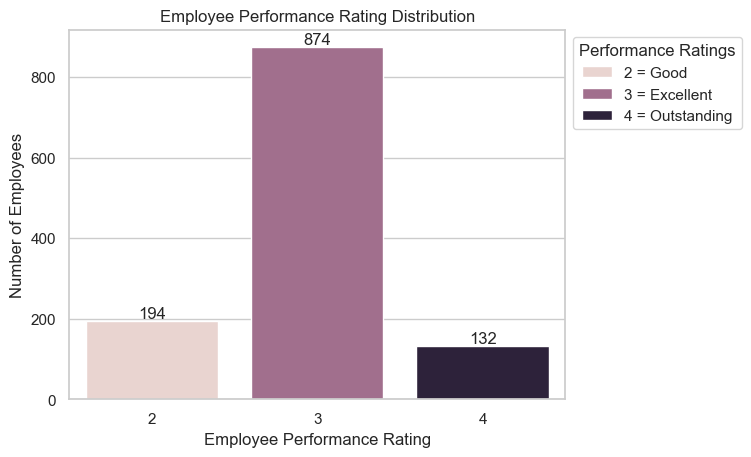

In [10]:
# Countplot of Performance Ratings
fig = sns.countplot(data=data, x = "PerformanceRating", hue = "PerformanceRating")
for container in fig.containers:
    fig.bar_label(container, fmt='%.0f', fontsize = 12)
plt.xlabel("Employee Performance Rating")
plt.ylabel("Number of Employees")
plt.legend(["2 = Good", "3 = Excellent", "4 = Outstanding"],title = "Performance Ratings", bbox_to_anchor = (1,1), loc = "upper left")
plt.title("Employee Performance Rating Distribution")
#plt.savefig("Employee Performance Rating Distribution.png", bbox_inches = 'tight', dpi = 400)
plt.show()

**Comments on Employee Performance Rating Distribution**

Most employees received a performance rating of Excellent. Notably there were no employees that received a Low (1) performance rating. There is quite a pronounced imbalance in the number of employees between the three classes which will need to be factored into the training of models in future to avoid sub-optimal model performance on Good and Outstanding ratings.

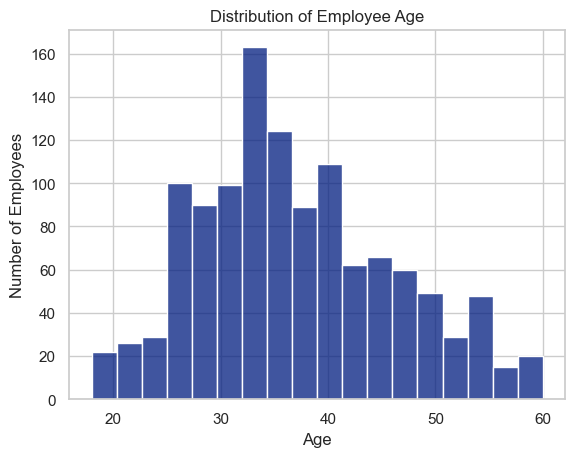

In [11]:
# Histogram of the Employee Age
sns.histplot(data=data, x = "Age")
plt.ylabel("Number of Employees")
plt.title("Distribution of Employee Age")
#plt.savefig("Employee Age Distribution.png", bbox_inches = 'tight', dpi = 400)
plt.show()

**Comments on Employee Age Distribution**

The company had the a wide distribution of employee ages from 18 years to 60 with the most common employee cohort being the 32-34 years age range. 

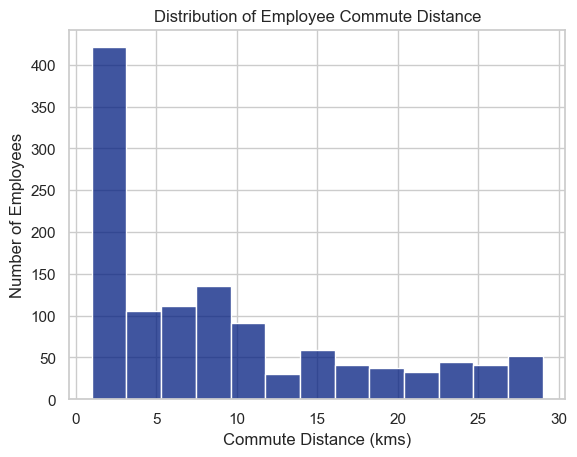

In [12]:
# Histogram of the Employee Commute Distance
sns.histplot(data=data, x = "DistanceFromHome")
plt.ylabel("Number of Employees")
plt.xlabel("Commute Distance (kms)")
plt.title("Distribution of Employee Commute Distance")
#plt.savefig("Employee Commute Distance Distribution.png", bbox_inches = 'tight', dpi = 400)
plt.show()

**Comments on Employee Commute Distance Distribution**

All employees commuted fewer than 30 kilometres* to get to the office. Most employees only needed to commute 0-2.5 kilometres.

*An assumption was made that the data recorded were in kilometres given that no location was specified for the company and the kilometre is one of the SI units for distance.

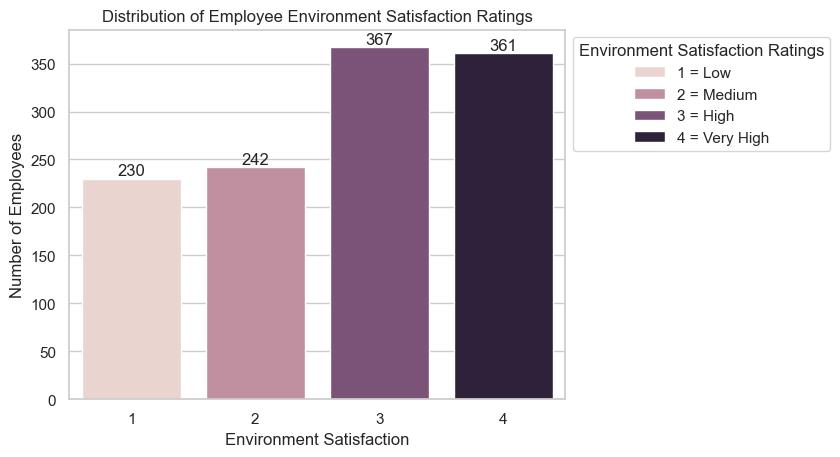

In [13]:
# Countplot of the Employee Environment Satisfaction
fig = sns.countplot(data=data, x = "EmpEnvironmentSatisfaction", hue = "EmpEnvironmentSatisfaction")
plt.ylabel("Number of Employees")
plt.xlabel("Environment Satisfaction")
plt.title("Distribution of Employee Environment Satisfaction Ratings")
for container in fig.containers:
    fig.bar_label(container, fmt='%.0f', fontsize = 12)
plt.legend(["1 = Low", "2 = Medium", "3 = High", "4 = Very High"], title = "Environment Satisfaction Ratings", bbox_to_anchor = (1,1), loc = "upper left")
#plt.savefig("Employee Environment Satisfaction Ratings Distribution.png", bbox_inches = 'tight', dpi = 400)
plt.show()

**Comments on Employee Environment Satisfaction Distribution**

The majority of employees had favourable view (high or very high rating) of the office environment.

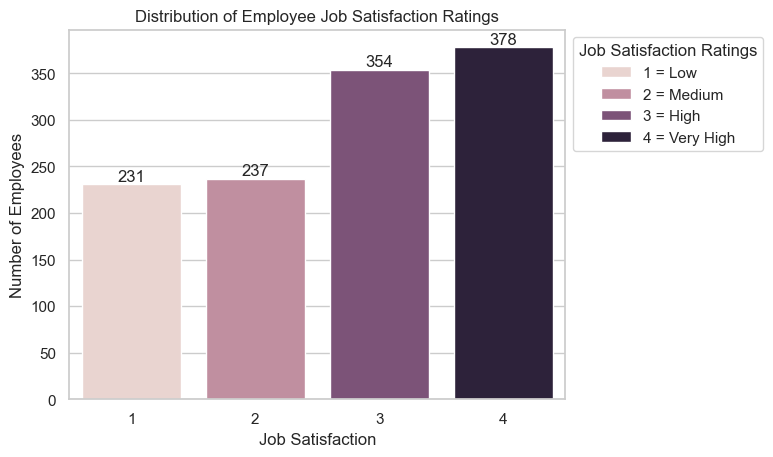

In [14]:
# Countplot of the Employee Job Satisfaction
fig = sns.countplot(data=data, x = "EmpJobSatisfaction", hue = "EmpJobSatisfaction")
plt.ylabel("Number of Employees")
plt.xlabel("Job Satisfaction")
plt.title("Distribution of Employee Job Satisfaction Ratings")
for container in fig.containers:
    fig.bar_label(container, fmt='%.0f', fontsize = 12)
plt.legend(["1 = Low", "2 = Medium", "3 = High", "4 = Very High"], title = "Job Satisfaction Ratings", bbox_to_anchor = (1,1), loc = "upper left")
#plt.savefig("Employee Job Satisfaction Distribution.png", bbox_inches = 'tight', dpi = 400)
plt.show()

**Comments on Employee Job Satisfaction Ratings Distribution**

The majority of employees had a favourable view (high or very high rating) of their satisfaction with their job.

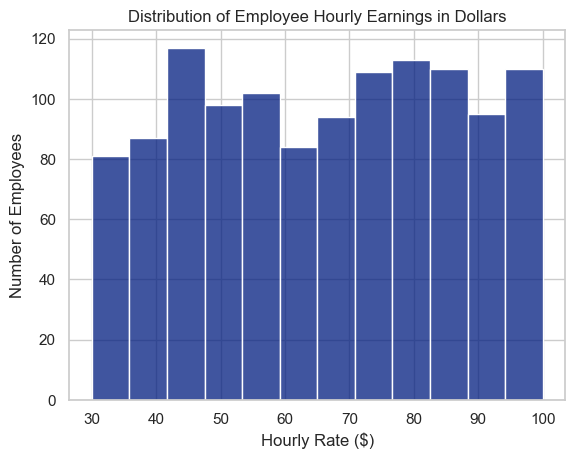

In [15]:
# Histogram of the Employee Hourly Rate
sns.histplot(data=data, x = "EmpHourlyRate")
plt.ylabel("Number of Employees")
plt.xlabel("Hourly Rate ($)")
plt.title("Distribution of Employee Hourly Earnings in Dollars")
#plt.savefig("Employee Hourly Rate Distribution.png", bbox_inches = 'tight', dpi = 400)
plt.show()

**Comments on Employee Hourly Earnings Distribution**

Distribution appeared to be largely uniform with the largest cohort of employees earning between $40-45*

*Similarly to the commute distance distribution, due to no geographical location being specified for the company, an assumption was made that the hourly rate data were priced in US dollars given that it is the world's reserve currency and forms the basis of most of the world's trade.

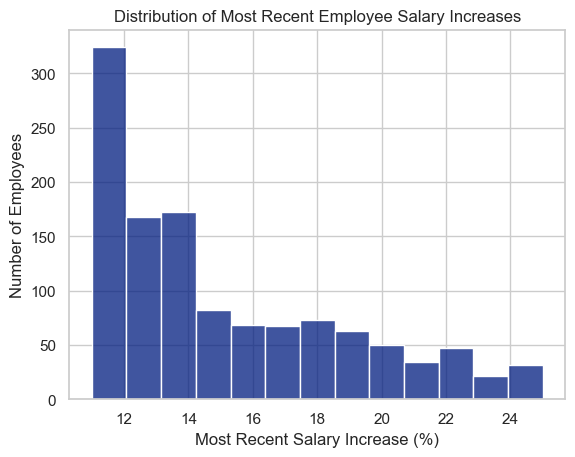

In [16]:
# Histogram of the Employee Most Recent Pay Increase Percentage
sns.histplot(data=data, x = "EmpLastSalaryHikePercent")
plt.ylabel("Number of Employees")
plt.xlabel("Most Recent Salary Increase (%)")
plt.title("Distribution of Most Recent Employee Salary Increases")
#plt.savefig("Employee Most Recent Salary Hike Distribution.png", bbox_inches = 'tight', dpi = 400)
plt.show()

**Comments on Most Recent Salary Increase Percentage Distribution**

The pay increases appeared to be heavily right-skewed with certain employees able to command outsized salary advancements. The largest cohort of employees received pay increases of 11%.

## Departmental Breakdowns

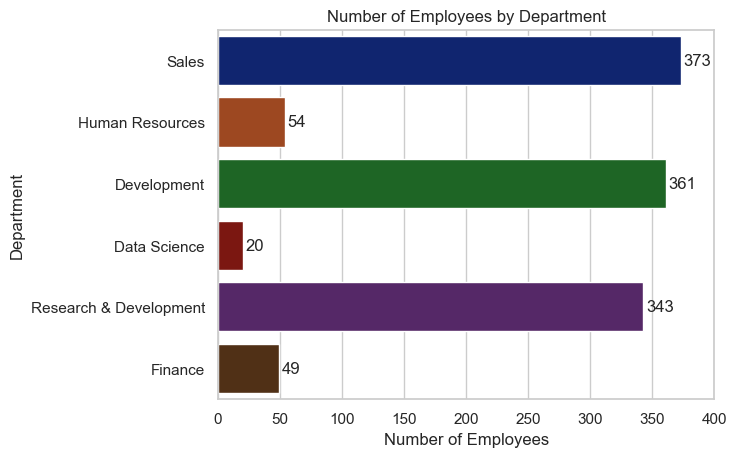

In [17]:
# Countplot of Employees Per Department
fig = sns.countplot(data = data, y = "EmpDepartment", hue = "EmpDepartment")
for container in fig.containers:
    fig.bar_label(container, fmt='%.0f', fontsize = 12, padding = 2)
plt.xlabel("Number of Employees")
plt.ylabel("Department")
plt.title("Number of Employees by Department")
plt.xlim(0,400)
#plt.savefig("Headcount per Department.png", bbox_inches = 'tight', dpi = 400)
plt.show()

**Comments on Number of Employees by Department**

There were large differences in the employee headcount between the three largest departments and the three smallest.

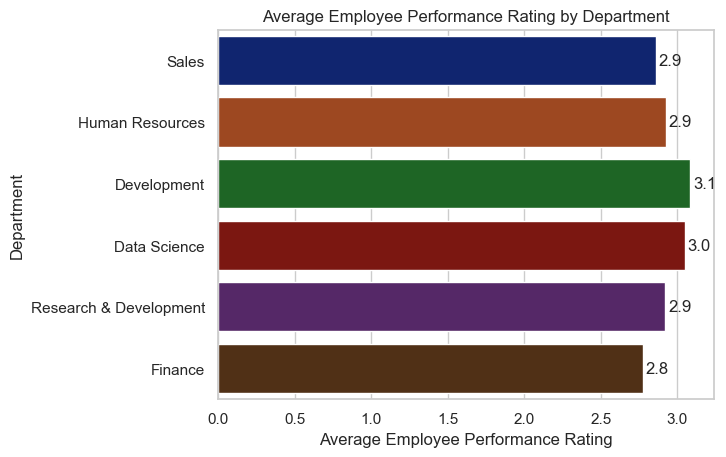

In [18]:
# Barplot of Employee Performance Ratings by Department
fig = sns.barplot(data = data, x = "PerformanceRating", y = 'EmpDepartment', hue = "EmpDepartment", errorbar = ('ci', False))
for container in fig.containers:
    fig.bar_label(container, fmt='%.1f', fontsize = 12, padding = 2)
plt.ylabel("Department")
plt.xlabel("Average Employee Performance Rating")
plt.title("Average Employee Performance Rating by Department")
#plt.savefig("Average Employee Performance Rating per Department.png", bbox_inches = 'tight', dpi = 400)
plt.show()

**Comments on Average Employee Performance Ratings by Department**

Only two departments were able to achieve an overall average performance rating of Excellent (3) with rest being rated in the Good category(2-3). Worryingly, the Finance department was the worst-performing department.

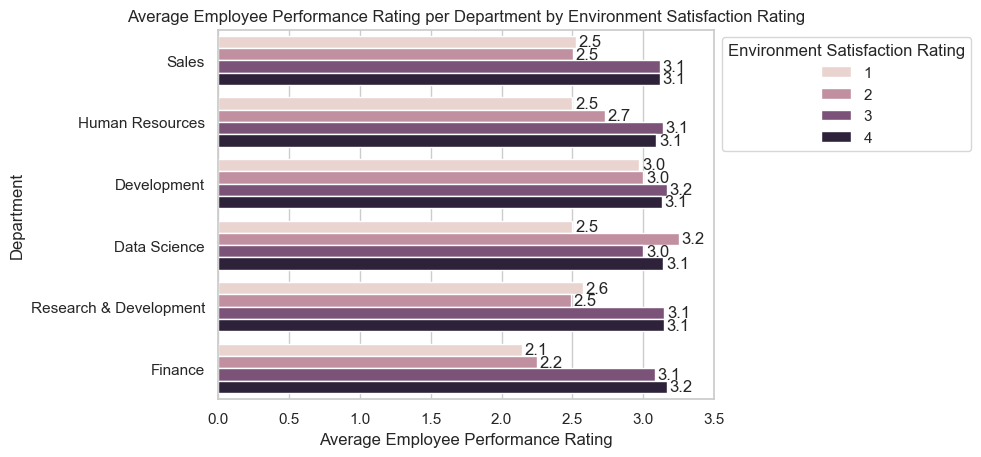

In [19]:
# Barplot of Employee Performance Ratings by Department per Department by Environment Satisfaction Rating
fig = sns.barplot(data = data, x = "PerformanceRating", y = 'EmpDepartment', hue = "EmpEnvironmentSatisfaction", errorbar = ('ci', False))
for container in fig.containers:
    fig.bar_label(container, fmt='%.1f', fontsize = 12, padding = 2)
plt.ylabel("Department")
plt.xlim(0,3.5)
plt.xlabel("Average Employee Performance Rating")
plt.title("Average Employee Performance Rating per Department by Environment Satisfaction Rating")
plt.legend(title = "Environment Satisfaction Rating", bbox_to_anchor = (1,1), loc = "upper left")
#plt.savefig("Average Employee Performance Rating per Department by Environment Satisfaction Rating.png", bbox_inches = 'tight', dpi = 400)
plt.show()

**Comments on Average Employee Performance Rating per Department by Environment Satisfaction Rating**

Across five of the six departments, those with Low (1) or Medium (2) environment satisfaction ratings had lower average performance ratings than those with more favourable views on the office environment. 
Given the magnitude of the difference between the lower and upper scale rating classes, this was identified as a potentially significant differentiating factor for employee performance. 

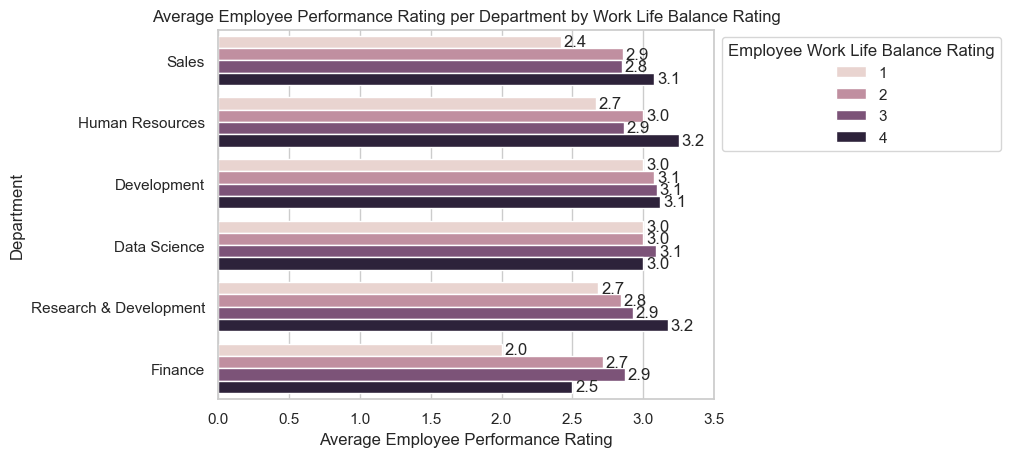

In [20]:
# Barplot of Employee Performance Ratings by Department per Department by Environment Satisfaction Rating
fig = sns.barplot(data = data, x = "PerformanceRating", y = 'EmpDepartment', hue = "EmpWorkLifeBalance", errorbar = ('ci', False))
for container in fig.containers:
    fig.bar_label(container, fmt='%.1f', fontsize = 12, padding = 2)
plt.ylabel("Department")
plt.xlim(0,3.5)
plt.xlabel("Average Employee Performance Rating")
plt.title("Average Employee Performance Rating per Department by Work Life Balance Rating")
plt.legend(title = "Employee Work Life Balance Rating", bbox_to_anchor = (1,1), loc = "upper left")
#plt.savefig("Average Employee Performance Rating per Department by Work Life Balance Rating.png", bbox_inches = 'tight', dpi = 400)
plt.show()

**Comments on Average Employee Performance Rating per Department by Work Life Balance Rating**

Similarly to Environment Satisfaction, across five of the six departments, those with Low (1) or Medium (2) work life balance ratings had lower average performance ratings than those with more favourable views.

In the Finance department, even those with highly-rated work life balance are achieving sub-optimal performance ratings. Given the low headcount, this could indicate a work overload.

In [21]:
# Barplot of Employee Job Satisfaction Ratings per Department by Overtime Requirement
fig = sns.barplot(data = data, x = "EmpJobSatisfaction", y = 'EmpDepartment', hue = "OverTime", errorbar = ('ci', False))
for container in fig.containers:
    fig.bar_label(container, fmt='%.1f', fontsize = 11, padding = 2)
plt.legend(title = "Overtime Required", bbox_to_anchor = (1,1), loc = "upper left")
plt.xlabel("Average Employee Job Satisfaction Rating")
plt.ylabel("Department")
plt.title('Average Employee Job Satisfaction Rating per Department by Overtime Requirement')
#plt.savefig("Employee Job Satisfaction per Department by Overtime Requirement.png", bbox_inches = 'tight', dpi = 400)
plt.show()


KeyboardInterrupt: 

**Comments on Employee Job Satisfaction per Department by Overtime Requirement**

The breakdown of job satisfaction per department by overtime requirement yielded some interesting results. In certain departments such as Sales, Data Science, Human Resources and Finance employees who were required to work overtime had higher average job satisfaction ratings than those that were not required. However, the Research & Development and Development departments showed adverse job satisfaction ratings for employees required to work overtime.

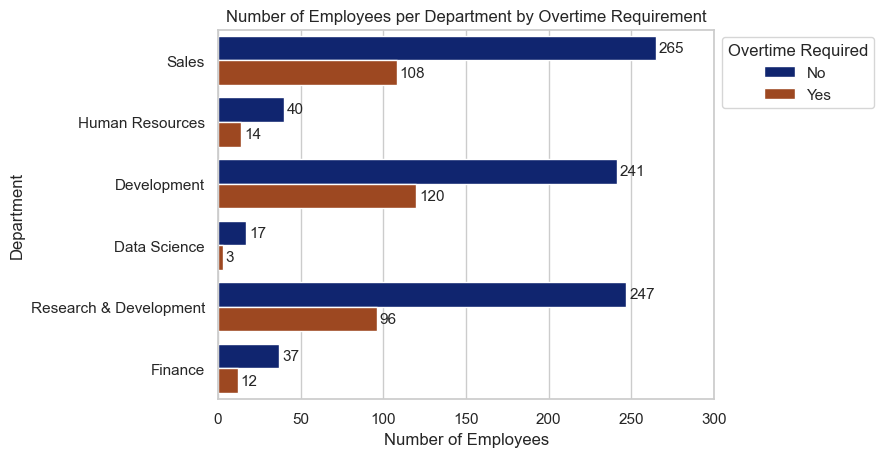

In [ ]:
# Countplot of Employees Per Department by Overtime Requirement
fig = sns.countplot(data = data, y = "EmpDepartment", hue = "OverTime")
for container in fig.containers:
    fig.bar_label(container, fmt='%.0f', fontsize = 11, padding = 2)
plt.legend(title = "Overtime Required", bbox_to_anchor = (1,1), loc = "upper left")
plt.xlabel("Number of Employees")
plt.ylabel("Department")
plt.xlim(0,300)
plt.title("Number of Employees per Department by Overtime Requirement")
#plt.savefig("Number of Employees per Department by Ovetime Requirement.png", bbox_inches = 'tight', dpi = 400)
plt.show()

**Comments on Number of Employees per Department by Overtime Requirement**

All departments had a higher number of employees not required to work overtime than those required to. The Development department had the highest proportion of overtime-required employees at 49.79%

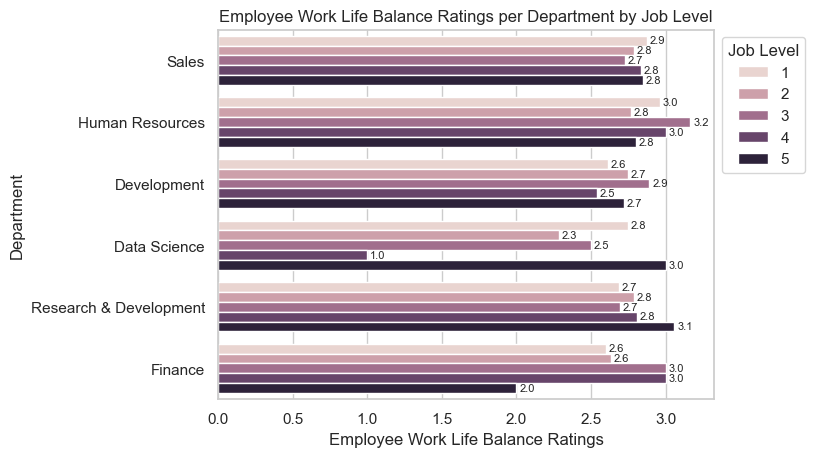

In [ ]:
# Barplot of Employee Job Satisfaction Ratings per Department by Job Level
fig = sns.barplot(data = data, x = "EmpWorkLifeBalance", y = 'EmpDepartment', hue = "EmpJobLevel", errorbar = ('ci', False))
for container in fig.containers:
    fig.bar_label(container, fmt='%.1f', fontsize = 8, padding = 2)
plt.legend(title = "Job Level", bbox_to_anchor = (1,1), loc = "upper left")
plt.xlabel("Employee Work Life Balance Ratings")
plt.ylabel("Department")
plt.title("Employee Work Life Balance Ratings per Department by Job Level")
#plt.savefig("Employee Work Life Balance Ratings per Department by Job Level.png", bbox_inches = 'tight', dpi = 400)
plt.show()

**Comments on Employee Work Life Balance Ratings per Department by Job Level**

The breakdown of employee work life balance per department and then by job level did not reveal any universal trends such as an increase or decrease in work life balance with increasing for decreasing job level. 

However, two noticeable findings were very poor work life balance ratings ("Bad". 1) for the second-highest (4) job level in the Data Science department as well as lower average rating for the highest job level (5) in the Finance department.

## Relationships

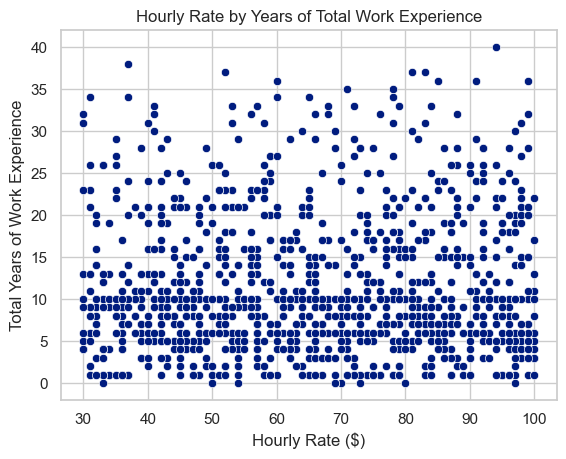

In [ ]:
# Scatterplot of Hourly Earnings by Total Work Experience
sns.scatterplot(data, x = 'EmpHourlyRate', y = 'TotalWorkExperienceInYears')
plt.xlabel("Hourly Rate ($)")
plt.ylabel("Total Years of Work Experience")
plt.title("Hourly Rate by Years of Total Work Experience")
#plt.savefig("Hourly Rate by Years of Total Work Experience.png", bbox_inches = 'tight', dpi = 400)
plt.show()

**Comments on Hourly Rate by Total Years of Work Experience**

There appeared to not be any relationship between hourly rate and number of years of total work experience. 

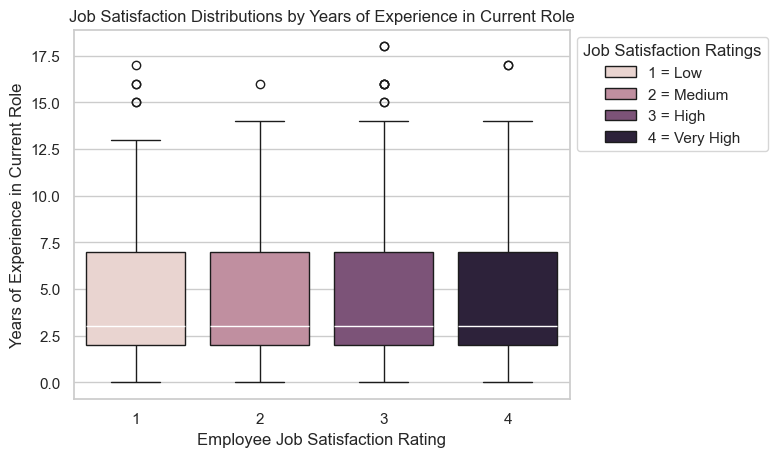

In [ ]:
# Barplot of Employee by Department
fig = sns.boxplot(data = data, x = "EmpJobSatisfaction", y = "ExperienceYearsInCurrentRole", hue = "EmpJobSatisfaction", medianprops=dict(color='white'))
plt.legend(["1 = Low", "2 = Medium", "3 = High", "4 = Very High"], title = "Job Satisfaction Ratings", bbox_to_anchor = (1,1), loc = "upper left")
plt.xlabel("Employee Job Satisfaction Rating")
plt.ylabel("Years of Experience in Current Role")
plt.title('Job Satisfaction Distributions by Years of Experience in Current Role')
#plt.savefig("Job Satisfaction Distributions by Years of Experience in Current Role.png", bbox_inches = 'tight', dpi = 400)
plt.show()

**Comments on Employee Job Satisfaction Ratings by Years of Work Experience in Current Role**

The work experience distributions between the different employee job satisfaction categories appeared to be largely equal as can be seen by the roughly equal median values indicated by the white lines in the box sections. The 75th percentile for the Low satisfaction category was marginally lower than for the other satisfaction categories potentially indicating people who are still in a stage where the job is so new that there are heightened stress levels from dealing with a lot of novel situations or problems which could lead to lower job satisfaction.

## Correlations and Feature Engineering

In [ ]:
# Encoding the Gender, Marital Status, Business Travel Frequency, Overtime and Attrition Features using One-Hot Encoding
data_encoded = pd.get_dummies(data, columns=['Gender', 'MaritalStatus', 'BusinessTravelFrequency', 'OverTime', 'Attrition'], drop_first=True) 
data_encoded.head()

,Age,EducationBackground,EmpDepartment,EmpJobRole,DistanceFromHome,EmpEducationLevel,EmpEnvironmentSatisfaction,EmpHourlyRate,EmpJobInvolvement,EmpJobLevel,...,YearsSinceLastPromotion,YearsWithCurrManager,PerformanceRating,Gender_Male,MaritalStatus_Married,MaritalStatus_Single,BusinessTravelFrequency_Travel_Frequently,BusinessTravelFrequency_Travel_Rarely,OverTime_Yes,Attrition_Yes
0,32,Marketing,Sales,Sales Executive,10,3,4,55,3,2,...,0,8,3,True,False,True,False,True,False,False
1,47,Marketing,Sales,Sales Executive,14,4,4,42,3,2,...,1,7,3,True,False,True,False,True,False,False
2,40,Life Sciences,Sales,Sales Executive,5,4,4,48,2,3,...,1,12,4,True,True,False,True,False,True,False
3,41,Human Resources,Human Resources,Manager,10,4,2,73,2,5,...,12,6,3,True,False,False,False,True,False,False
4,60,Marketing,Sales,Sales Executive,16,4,1,84,3,2,...,2,2,3,True,False,True,False,True,False,False


In [ ]:
# Encoding the Educational Background, Department, Job Role and Performance Rating Features using Label Encoding
le_edback = LabelEncoder()
le_empdep = LabelEncoder()
le_emjbr = LabelEncoder()
le_pfr = LabelEncoder()

# ^ Seperate Label Encoders instantiated to allow for easier export and use in conjunction with the final trained machine learning model. 

data_encoded['EducationBackground'] = le_edback.fit_transform(data_encoded['EducationBackground'])
data_encoded['EmpDepartment'] = le_empdep.fit_transform(data_encoded['EmpDepartment'])
data_encoded['EmpJobRole'] = le_emjbr.fit_transform(data_encoded['EmpJobRole'])
data_encoded['PerformanceRating'] = le_pfr.fit_transform(data_encoded['PerformanceRating'])
data_encoded.head()


,Age,EducationBackground,EmpDepartment,EmpJobRole,DistanceFromHome,EmpEducationLevel,EmpEnvironmentSatisfaction,EmpHourlyRate,EmpJobInvolvement,EmpJobLevel,...,YearsSinceLastPromotion,YearsWithCurrManager,PerformanceRating,Gender_Male,MaritalStatus_Married,MaritalStatus_Single,BusinessTravelFrequency_Travel_Frequently,BusinessTravelFrequency_Travel_Rarely,OverTime_Yes,Attrition_Yes
0,32,2,5,13,10,3,4,55,3,2,...,0,8,1,True,False,True,False,True,False,False
1,47,2,5,13,14,4,4,42,3,2,...,1,7,1,True,False,True,False,True,False,False
2,40,1,5,13,5,4,4,48,2,3,...,1,12,2,True,True,False,True,False,True,False
3,41,0,3,8,10,4,2,73,2,5,...,12,6,1,True,False,False,False,True,False,False
4,60,2,5,13,16,4,1,84,3,2,...,2,2,1,True,False,True,False,True,False,False


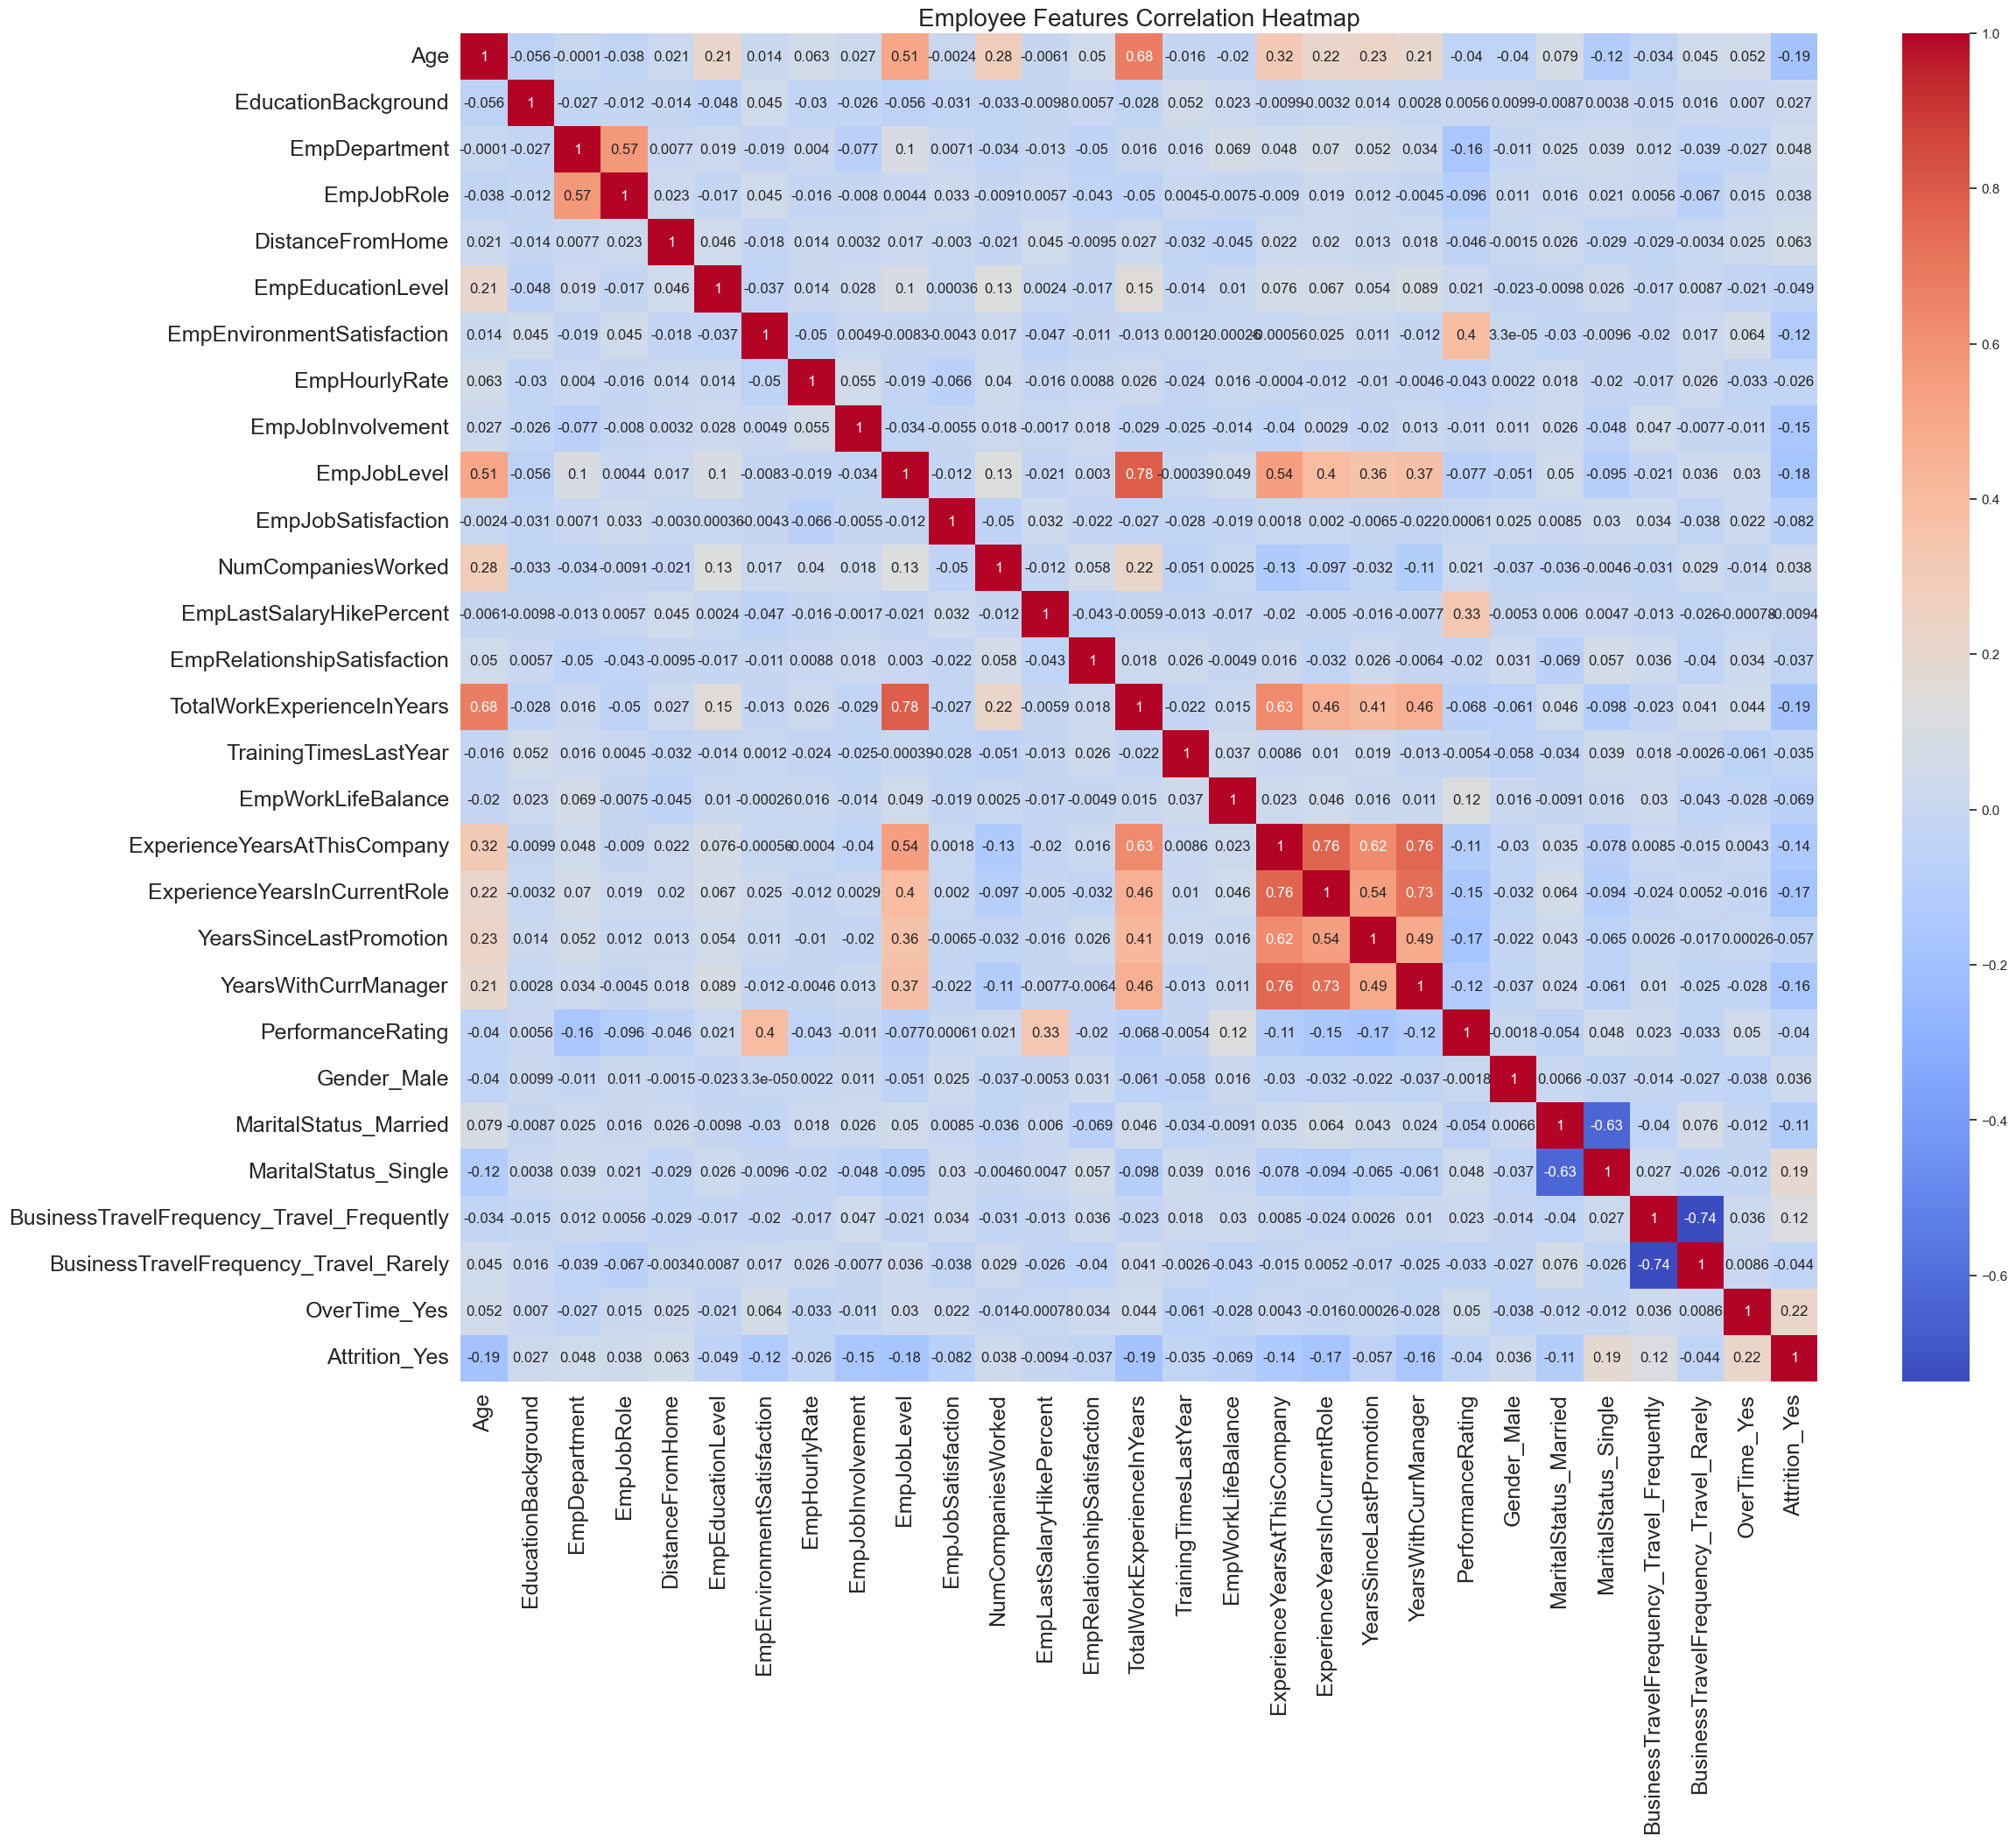

In [ ]:
# Features Correlation Heatmap
plt.figure(figsize = (25,20))
sns.heatmap(data_encoded.corr(), cmap = 'coolwarm', annot = True)
plt.title("Employee Features Correlation Heatmap", fontsize = 20)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
#plt.savefig("Employee Features Correlation Heatmap.png", bbox_inches = 'tight', dpi = 400)
plt.show()

**Comments on Feature Correlations Heatmap**

**Notable Correlations**
 
 - Total Years of Work Experience and Age are moderately positive correlated.
 - Total Years of Work Experience and Job Level are strongly positively correlated.
 - Business Travel Frequency categories are moderately negatively correlated.
 - Marital Status categories are moderately negatively correlated.
 - Years of Experience at the Company and Years with Current Manager are strongly positively correlated. This combined with the strong positive correlation with Years of Experience in Current Role indicate a slow rate of progression in the job level strucuture within the company through promotion. 

**Notable Correlations with Employee Performance Rating**

- Employee Environment Satisfaction and the magnitude of the last salary increase in percentage terms were the two most highly correlated features to Employee Performance Rating with moderate positive correlations of 0.4 and 0.33, respectively. 

**Multicollinearity**

- Using a threshold of 0.8, there were no instances of multicollinearity detected based on the above feature correlations heatmap. 

## Principal Component Analysis

In [ ]:
# Creating the Features Dataset
X_pca_data = data_encoded.drop(columns=['PerformanceRating'], axis = 0)
y = data_encoded['PerformanceRating']

In [ ]:
#Scaling the Data
scaler_pca = StandardScaler()
X_pca_scaled = scaler_pca.fit_transform(X_pca_data)

In [ ]:
#Performing Principal Component Analysis with 2 Components
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X_pca_scaled)

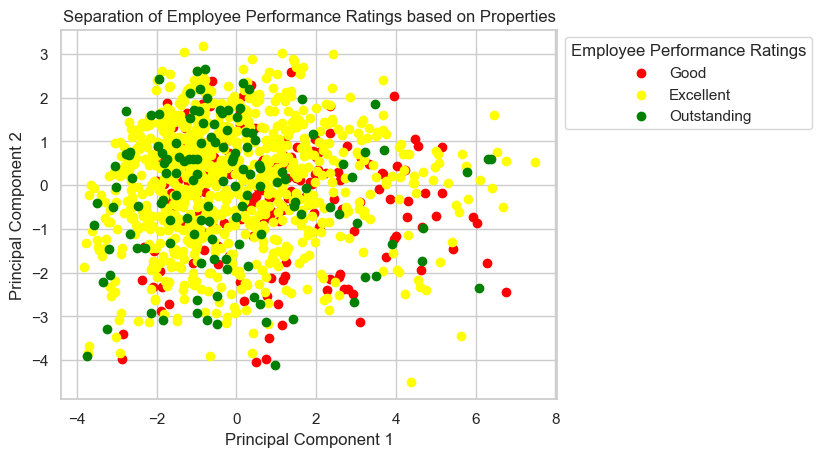

In [ ]:
colour = ['red', 'yellow', 'green']
target_names = ["Good", "Excellent", "Outstanding"]

for colour, i, target_name in zip(colour, [0,1,2], target_names):    
    plt.scatter(X_pca[y==i,0], X_pca[y==i,1], c = colour, label = target_name)
plt.legend(title = "Employee Performance Ratings", bbox_to_anchor = (1,1), loc = "upper left")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title("Separation of Employee Performance Ratings based on Properties")
#plt.savefig("Employee Performance Ratings Principal Component Analysis.png", bbox_inches = 'tight', dpi = 400)
plt.show()

**Comments on Employee Principal Component Analysis**

There does not appear to be a clear separation betweeen the three performance rating classes.

In [ ]:
# Determining How Many Principal Components Would Be Needed to Explain 95% of the Variance within the Dataset
pca_variance = PCA(n_components = 23)
X_pca_variance = pca_variance.fit_transform(X_pca_scaled)
pca_variance.explained_variance_ratio_.cumsum()

array([0.14924874, 0.21716707, 0.27680784, 0.33408509, 0.38990238,
       0.43596929, 0.47755452, 0.51780311, 0.55655354, 0.59371823,
       0.62940527, 0.66499773, 0.69941028, 0.73327286, 0.76635624,
       0.79888695, 0.8303531 , 0.86121609, 0.88830455, 0.90901841,
       0.92758652, 0.94305776, 0.95756033])

# Machine Learning

**Outline of Section Contents**

The following section contains the model training to be able to predict employee performance rating. The dataset was initially split into a target variable (Performance Rating) and remaining features dataset before being split into training and testing datasets. The five model types were then initially fitted on the training dataset and evaluated based on cross validation accuracy and weighted average f1 score. The classification reports were also generated.

The top-performing model in the initial fitting was then used to perform a feature importance analysis. The results of this were used to generate a reduced feature set to improve usability. A secondary fitting on this reduced feature set was then performed using the same models and evaluation methodology as the initial fitting. 

Hyperparameter tuning was performed on the top-performing model from the secondary fitting using GridSearchCV. The default initialisation parameters were returned as the best option. This model was finally exported for use in a web deployment.

## Data Preparation

In [ ]:
# Splitting the Encoded Dataset into Features and the Target Variable
X = data_encoded.drop(columns=['PerformanceRating'], axis=0)
y = data_encoded['PerformanceRating']

In [ ]:
#Splitting into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) #Stratification added due to the class imbalance detected during the Exploratory Data Analysis

In [ ]:
# Scaling the Data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Initial Model Fitting and Evaluation

In [ ]:
#Defining the Candidate Models
models = { #Balanced Class Weights added to models with the parameter available due to the class imbalance detected during the Exploratory Data Analysis
    "Logistic Regression" : LogisticRegression(random_state=42, class_weight='balanced'),
    "Decision Tree Classifier": DecisionTreeClassifier(random_state = 42, class_weight = 'balanced'),
    "Random Forest Classifier": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "Gradient Boosting Classifier": GradientBoostingClassifier(random_state=42),
    "XG Boost Classifier": xgb.XGBClassifier()
}

In [ ]:
# Fitting and Evaluating the Candidate Models using Stratified K Fold Cross Validation
outs_kf_class = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Stratified K Fold Cross Validation used due to the class imbalance detected during the Exploratory Data Analysis

for name, model in models.items():

    start_time = time.time()

    accuracy = np.mean(cross_val_score(model, X_train, y_train, cv=kf, scoring= 'accuracy'))
    f1 = np.mean(cross_val_score(model, X_train, y_train, cv = kf, scoring= 'f1_weighted')) # Weighted f1 Score used instead of a macro or micro average to give a better idea of how performance is between the different classes

    end_time = time.time()

    elapsed_time = end_time - start_time

    out = pd.DataFrame(np.empty((1, 4)) * np.nan)

    out.columns = ["Model Name", "Accuracy", "F1 Score", "Runtime (seconds)"]

    out.iloc[0,0] = name
    out.iloc[0,1] = accuracy
    out.iloc[0,2] = f1
    out.iloc[0,3] = np.round(elapsed_time,3)

    outs_kf_class.append(out)


outs_kf_class = pd.concat(outs_kf_class)
outs_kf_class = outs_kf_class.reset_index(drop=True)

In [ ]:
outs_kf_class

,Model Name,Accuracy,F1 Score,Runtime (seconds)
0,Logistic Regression,0.695238,0.713587,0.055
1,Decision Tree Classifier,0.876190,0.875774,0.046
2,Random Forest Classifier,0.911905,0.907651,1.278
3,Gradient Boosting Classifier,0.927381,0.926601,4.260
4,XG Boost Classifier,0.921429,0.920116,2.645


**Comments on Initial Model Fitting Cross Validation Outcomes**

All models showed reasonable to good performance across accuracy and weighted average f1 scores. The Gradient Boosting Classifier was marginally the top performer on both metrics.

In [ ]:
# Generating the Classsification Reports
for name, model in models.items():

    m = model.fit(X_train, y_train)
    y_pred = m.predict(X_test)
    report = classification_report(y_test, y_pred)
    print(f"{name} Classification Report\n{report}")

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.46      0.74      0.57        58
           1       0.93      0.73      0.81       262
           2       0.53      0.82      0.65        40

    accuracy                           0.74       360
   macro avg       0.64      0.76      0.68       360
weighted avg       0.81      0.74      0.76       360

Decision Tree Classifier Classification Report
              precision    recall  f1-score   support

           0       0.79      0.76      0.77        58
           1       0.94      0.93      0.94       262
           2       0.84      0.95      0.89        40

    accuracy                           0.91       360
   macro avg       0.86      0.88      0.87       360
weighted avg       0.91      0.91      0.91       360

Random Forest Classifier Classification Report
              precision    recall  f1-score   support

           0       0.89      0.86      0.88    

**Comments on Initial Model Fitting and Evaluation**

The steps taken to ensure balanced model performance such as the stratifying of the samples, use of Stratified K-Fold cross validation and setting of the class weights parameter to balanced appeared to have resulted in favourable outcomes. All models showed a good balance of precision and recall performance accross the three classes. The XG Boost Classifier was the top performer based on the classification report and was the second-best performer in the cross validation evaluation.

Based on both of these assessments it was selected as the top-performing model in the initial fitting and was selected for use in the feature importance analysis.

## Feature Importance Analysis

In [ ]:
# Retrieving the Feature Importances from the Best-Performing Model in the Initial Evaluation
mod = xgb.XGBClassifier()
mod.fit(X_train, y_train)

feature_importances = pd.Series(mod.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_importances)

EmpEnvironmentSatisfaction                   0.195073
YearsSinceLastPromotion                      0.154226
EmpLastSalaryHikePercent                     0.118260
EmpDepartment                                0.063800
EmpJobRole                                   0.057281
ExperienceYearsInCurrentRole                 0.049067
EmpWorkLifeBalance                           0.044832
YearsWithCurrManager                         0.027621
ExperienceYearsAtThisCompany                 0.022769
EmpJobInvolvement                            0.022534
TrainingTimesLastYear                        0.020097
MaritalStatus_Married                        0.019330
OverTime_Yes                                 0.018145
Attrition_Yes                                0.017348
MaritalStatus_Single                         0.017220
BusinessTravelFrequency_Travel_Frequently    0.016369
EducationBackground                          0.014867
DistanceFromHome                             0.014524
EmpHourlyRate               

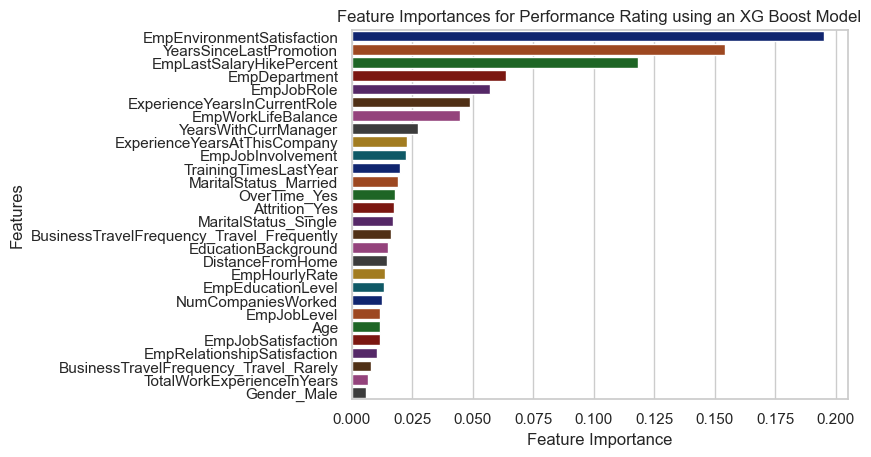

In [ ]:
# Plotting the Feature Importances
sns.barplot(x = feature_importances, y = feature_importances.index, palette= 'dark')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importances for Performance Rating using an XG Boost Model")
#plt.savefig("Feature Importances.png", bbox_inches = 'tight', dpi = 400)
plt.show()

**Comments on Feature Importance Rankings**

Employee Environment Satisfaction was ranked as the most important feature for predicting employee performance. It is unclear whether this is referring to the actual decor/infrastructure of the office or the collection of relationships in the office. For the purpose of this analysis, the assumption will be made that it was referring to the office decor/aesthetic.

Three measures in the top ten refer directly or indirectly to time spent in a particular role: Years Since Last Promotion, Experience Years in Current Role and Years with Current Manager.

The magnitude of the last salary hike was also notably high in predictive power for employee performance.

In [ ]:
data_encoded.head()

,Age,EducationBackground,EmpDepartment,EmpJobRole,DistanceFromHome,EmpEducationLevel,EmpEnvironmentSatisfaction,EmpHourlyRate,EmpJobInvolvement,EmpJobLevel,...,YearsSinceLastPromotion,YearsWithCurrManager,PerformanceRating,Gender_Male,MaritalStatus_Married,MaritalStatus_Single,BusinessTravelFrequency_Travel_Frequently,BusinessTravelFrequency_Travel_Rarely,OverTime_Yes,Attrition_Yes
0,32,2,5,13,10,3,4,55,3,2,...,0,8,1,True,False,True,False,True,False,False
1,47,2,5,13,14,4,4,42,3,2,...,1,7,1,True,False,True,False,True,False,False
2,40,1,5,13,5,4,4,48,2,3,...,1,12,2,True,True,False,True,False,True,False
3,41,0,3,8,10,4,2,73,2,5,...,12,6,1,True,False,False,False,True,False,False
4,60,2,5,13,16,4,1,84,3,2,...,2,2,1,True,False,True,False,True,False,False


In [ ]:
feature_importances[10:len(feature_importances)].index 

Index(['TrainingTimesLastYear', 'MaritalStatus_Married', 'OverTime_Yes',
       'Attrition_Yes', 'MaritalStatus_Single',
       'BusinessTravelFrequency_Travel_Frequently', 'EducationBackground',
       'DistanceFromHome', 'EmpHourlyRate', 'EmpEducationLevel',
       'NumCompaniesWorked', 'EmpJobLevel', 'Age', 'EmpJobSatisfaction',
       'EmpRelationshipSatisfaction', 'BusinessTravelFrequency_Travel_Rarely',
       'TotalWorkExperienceInYears', 'Gender_Male'],
      dtype='object')

In [ ]:
# Removing Low-Importance Features
data_reduced = data_encoded.drop(columns=feature_importances[10:len(feature_importances)].index, axis=0)
data_reduced.head()

,EmpDepartment,EmpJobRole,EmpEnvironmentSatisfaction,EmpJobInvolvement,EmpLastSalaryHikePercent,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,PerformanceRating
0,5,13,4,3,12,2,10,7,0,8,1
1,5,13,4,3,12,3,7,7,1,7,1
2,5,13,4,2,21,3,18,13,1,12,2
3,3,8,2,2,15,2,21,6,12,6,1
4,5,13,1,3,14,3,2,2,2,2,1


## Secondary Model Fitting and Evaluation on Reduced Feature Set

In [ ]:
# Splitting the Reduced Encoded Dataset into Features and the Target Variable
X_reduced = data_reduced.drop(columns=['PerformanceRating'], axis=0)
y_reduced = data_reduced['PerformanceRating']

In [ ]:
#Splitting into Training and Testing Sets
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X_reduced, y_reduced, test_size=0.3, random_state=42, stratify=y_reduced) #Stratification added due to the class imbalance detected during the Exploratory Data Analysis

In [ ]:
# Scaling the Data
scaler_reduced = StandardScaler()
X_train_reduced = scaler_reduced.fit_transform(X_train_reduced)
X_test_reduced = scaler_reduced.transform(X_test_reduced)

In [ ]:
# Fitting and Evaluating the Candidate Models using Stratified K Fold Cross Validation
outs_kf_class_reduced = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Stratified K Fold Cross Validation used due to the class imbalance detected during the Exploratory Data Analysis

for name, model in models.items():

    start_time = time.time()

    accuracy = np.mean(cross_val_score(model, X_train_reduced, y_train_reduced, cv=kf, scoring= 'accuracy'))
    f1 = np.mean(cross_val_score(model, X_train_reduced, y_train_reduced, cv = kf, scoring= 'f1_weighted')) # Weighted f1 Score used instead of a macro or micro average to give a better idea of how performance is between the different classes

    end_time = time.time()

    elapsed_time = end_time - start_time

    out = pd.DataFrame(np.empty((1, 4)) * np.nan)

    out.columns = ["Model Name", "Accuracy", "F1 Score", "Runtime (seconds)"]

    out.iloc[0,0] = name
    out.iloc[0,1] = accuracy
    out.iloc[0,2] = f1
    out.iloc[0,3] = np.round(elapsed_time,3)

    outs_kf_class_reduced.append(out)


outs_kf_class_reduced = pd.concat(outs_kf_class_reduced)
outs_kf_class_reduced = outs_kf_class_reduced.reset_index(drop=True)

In [ ]:
outs_kf_class_reduced

,Model Name,Accuracy,F1 Score,Runtime (seconds)
0,Logistic Regression,0.721429,0.738660,0.047
1,Decision Tree Classifier,0.884524,0.884008,0.032
2,Random Forest Classifier,0.936905,0.935350,1.131
3,Gradient Boosting Classifier,0.930952,0.930555,2.792
4,XG Boost Classifier,0.917857,0.917173,0.964


In [ ]:
# Generating the Classsification Reports
for name, model in models.items():

    m = model.fit(X_train_reduced, y_train_reduced)
    y_pred = m.predict(X_test_reduced)
    report = classification_report(y_test_reduced, y_pred)
    print(f"{name} Classification Report\n{report}")

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.47      0.83      0.60        58
           1       0.95      0.69      0.80       262
           2       0.49      0.82      0.61        40

    accuracy                           0.72       360
   macro avg       0.63      0.78      0.67       360
weighted avg       0.82      0.72      0.74       360

Decision Tree Classifier Classification Report
              precision    recall  f1-score   support

           0       0.83      0.78      0.80        58
           1       0.93      0.93      0.93       262
           2       0.73      0.82      0.78        40

    accuracy                           0.89       360
   macro avg       0.83      0.84      0.84       360
weighted avg       0.90      0.89      0.89       360

Random Forest Classifier Classification Report
              precision    recall  f1-score   support

           0       0.86      0.84      0.85    

**Comments on Secondary Model Fitting and Evaluation**

Most models showed a slight increase in performance on cross validation but a decrease mainly in precision and overall f1 scores on the classification report. 

The Random Forest Classifier was the top performer on both the cross validation and classification report and still maintained a good balance of precision and recall across all classes relative to the full feature set.

It was selected as the final model type to be used with the reduced feature set in a model deployment.

## Hyperparameter Tuning

In [ ]:
#XG Boost Hyperparameter Tuning using GridSearchCV

rf_model_tuned = RandomForestClassifier(random_state=42, class_weight='balanced')

#Define the Hyperparameters
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

#Initialising the GridSearchCV using Stratified K-Fold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator = rf_model_tuned, param_grid = param_grid, cv=cv, scoring='f1_weighted', n_jobs = -1) #n_jobs = -1 used to recruit all available processors in the machine to reduce time taken
grid_search.fit(X_train_reduced, y_train_reduced)
best_params_rf = grid_search.best_params_
print(best_params_rf)

{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [ ]:
# Fitting a XG Boost Model with the Tuned Hyperparameters

rf_optimum = RandomForestClassifier(random_state=42, class_weight='balanced', **best_params_rf)
rf_optimum.fit(X_train_reduced, y_train_reduced)
y_pred_rf = rf_optimum.predict(X_test_reduced)
report_rf = classification_report(y_test, y_pred_rf)
print(report_rf)

              precision    recall  f1-score   support

           0       0.86      0.84      0.85        58
           1       0.94      0.97      0.96       262
           2       1.00      0.82      0.90        40

    accuracy                           0.94       360
   macro avg       0.93      0.88      0.90       360
weighted avg       0.94      0.94      0.94       360



**Comments on Outcome of Hyperparameter Tuning**

The hyperparameter tuning exercise conducted using GridSearchCV returned the default initialisation parameters as the best-performing combination.

# Deep Learning

**Outline of Section Contents**

The following section contains the neural network construction and training to attempt to predict employee performance. Neural networks are known for their ability to learn complex relationships and given the high dimensionality of the dataset, neural networks seemed like a worthwile modelling option to test.

A balanced class weights dictionary was computed using the class proportions in the y_train dataset from the machine learning section to promote equal performance across all three classes given the class imbalance between the employee performance classes. The employee performance data were then re-encoded into binary arrays using tensorflow's to_categorical method to be suitable for deep learning. The data were then split into training and testing datasets similarly to the Machine Learning section and scaled using Standard Scaler.

The neural network model infrastructure employed was comprised of 5 Dense layers with Rectified Linear Unit activation functions with Batch Normalisation and 30% Dropout layers in between each to aid in regularisation and model training speed. A Softmax activation function was used on the output layer to return an array of probabilities. Weighted avereage f1 score and accuracy were used as the evaluation metrics. An Adam optimiser was used together with a categorical crossentropy loss function. An early stopping callback was initialised with a minimum delta of 0.001 and a patience of 10. The balanced class weights dictionary was also utilised for class weights.

While both the full feature set and reduced feature set achieved reasonable performance on the largest rating class (Excellent), there were notable shortcomings in precision and recall on the two smaller classes, possibly due to the relative small size of the dataset. Neural networks are known to require far larger training datasets than other machine learning model types.

## Initial Model Creation and Fitting

In [ ]:
# Computing the Balanced Class Weights to Ensure 

class_weights_sklearn = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=np.array(y_train)
)

class_weights_dict = dict(zip(np.unique(y_train), class_weights_sklearn))
print(f"Class Weights: {class_weights_dict}")

Class Weights: {np.int64(0): np.float64(2.0588235294117645), np.int64(1): np.float64(0.45751633986928103), np.int64(2): np.float64(3.0434782608695654)}


In [ ]:
# Re-encoding the Target Variable to be Suitable for Deep Learning
y_categorical = to_categorical(y)

In [ ]:
# Splitting into Training and Testing Sets
X_train_neural, X_test_neural, y_train_neural, y_test_neural = train_test_split(X, y_categorical, test_size=0.3, random_state=42, stratify=y) #Stratification added due to the class imbalance detected during the Exploratory Data Analysis

In [ ]:
# Scaling the Data
scaler_neural = StandardScaler()
X_train_neural = scaler_neural.fit_transform(X_train_neural)
X_test_neural = scaler_neural.transform(X_test_neural)

In [ ]:
## Model Instantiation
model = Sequential([
    Dense(512, activation='relu', input_shape=[(X_train_neural.shape[1])]), # Declaring the Input layer with a ReLu activation function and mapping it to the number of columns in the feature dataset
    BatchNormalization(),
    Dropout(0.3),
    Dense(512, activation='relu'), # Creating the First Hidden Layer with a ReLu activation function.
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'), # Creating the Second Hidden Layer with a ReLu activation function.
    BatchNormalization(),
    Dense(128, activation='relu'), # Creating the Third Hidden Layer with a ReLu activation function.
    BatchNormalization(),
    Dense(128, activation='relu'), # Creating the Fourth Hidden Layer with a ReLu activation function.
    BatchNormalization(),
    Dense(3, activation='softmax') # Creating the Output layer using a neuron for each possible outcome and a Softmax activation function
])

#Initialising the F1 Score Metric
f1 = F1Score(average='weighted')

# compile model
model.compile(optimizer='adam', # improve the weights and bias
              loss='categorical_crossentropy', # monitoring model perfomance
              metrics=[f1, 'accuracy']) # evaluation


# Implement Early Stopping
early_stopping = EarlyStopping(
    min_delta  = 0.001, #minimum amount of change to count as an improvement
    patience = 10, #how many epochs to wait before stopping
    restore_best_weights = True
)


# fit model
history = model.fit(
    X_train_neural, y_train_neural,
    batch_size=32,
    epochs=500,
    callbacks = [early_stopping],
    verbose=1,
    validation_split=0.2,
    class_weight = class_weights_dict
)

Epoch 1/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.3795 - f1_score: 0.4231 - loss: 1.2176 - val_accuracy: 0.6905 - val_f1_score: 0.7055 - val_loss: 1.0266
Epoch 2/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5223 - f1_score: 0.5447 - loss: 0.7222 - val_accuracy: 0.7500 - val_f1_score: 0.7274 - val_loss: 0.9059
Epoch 3/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6027 - f1_score: 0.6270 - loss: 0.6242 - val_accuracy: 0.7500 - val_f1_score: 0.6784 - val_loss: 0.7704
Epoch 4/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6562 - f1_score: 0.6810 - loss: 0.5587 - val_accuracy: 0.7321 - val_f1_score: 0.6437 - val_loss: 0.6808
Epoch 5/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7396 - f1_score: 0.7572 - loss: 0.4394 - val_accuracy: 0.7262 - val_f1_score: 0.6303 - val_loss: 0.6568
Epoch 6/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7515 - f1_score: 0.7688 - loss: 0.3991 - val_accuracy: 0.7262 - val_f1_score: 0.6303 - va

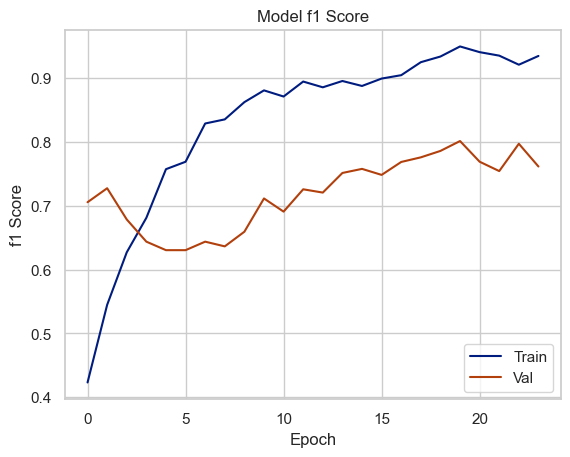

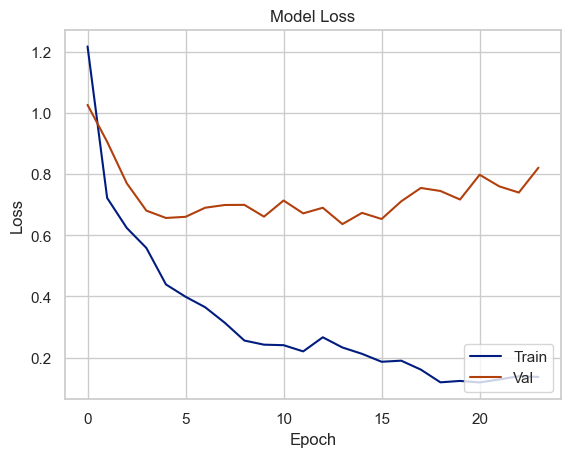

In [ ]:
# Plotting the Model F1 Score
plt.figure()
plt.plot(history.history['f1_score'], label="Train")
plt.plot(history.history['val_f1_score'], label="Val")
plt.title('Model f1 Score')
plt.ylabel('f1 Score')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

# Plotting the Model Loss
plt.figure()
plt.plot(history.history['loss'], label="Train")
plt.plot(history.history['val_loss'], label="Val")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Finding the Highest Cross Validation Weighted Average f1 Score and Accuracy
print(f"Highest Validation Weighted Average f1 Score: {max(history.history['val_f1_score'])}")
print(f"Highest Validation Accuracy: {max(history.history['val_accuracy'])}")

Highest Validation Weighted Average f1 Score: 0.8012880682945251
Highest Validation Accuracy: 0.8035714030265808


In [ ]:
# Evaluating the Model
loss, score, accuracy = model.evaluate(X_test_neural, y_test_neural)
print(f"Test Loss: {loss}, Test Weighted f1 Score: {score}, Test Accuracy: {accuracy}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7944 - f1_score: 0.7770 - loss: 0.5398 
Test Loss: 0.5398162603378296, Test Weighted f1 Score: 0.7769590616226196, Test Accuracy: 0.7944444417953491


In [ ]:
# Generating the Prediction Set
y_pred_neural = model.predict(X_test_neural)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [ ]:
# Creating a Function to Generate the Labels from the Prediction and Test sets to be able to Generate the Classification Report
def GetLabels(y_dat):

    y_labels = []

    for i in range(len(y_dat)):
        y_pos = np.argmax(y_dat[i]) #Finding the position of the highest-probability outcome
        y_labels.append(y_pos)

    y_labels = np.array(y_labels)

    return y_labels

In [ ]:
# Generating the Class Label Datasets
y_pred_labs = GetLabels(y_pred_neural)
y_test_labs = GetLabels(y_test_neural)

In [ ]:
# Generating the Classification Report
report = classification_report(y_test_labs, y_pred_labs)
print(report)

              precision    recall  f1-score   support

           0       0.63      0.45      0.53        58
           1       0.82      0.93      0.87       262
           2       0.80      0.40      0.53        40

    accuracy                           0.79       360
   macro avg       0.75      0.59      0.64       360
weighted avg       0.78      0.79      0.78       360



**Comments on Neural Network Performance**

Relatively good results on the largest employee performance class. However, notable drops in precision and recall on the smaller classes.

## Secondary Fitting on Reduced Feature Set

In [ ]:
# Splitting into Training and Testing Sets
X_train_neural_reduced, X_test_neural_reduced, y_train_neural_reduced, y_test_neural_reduced = train_test_split(X_reduced, y_categorical, test_size=0.3, random_state=42, stratify=y) #Stratification added due to the class imbalance detected during the Exploratory Data Analysis

In [ ]:
## Model Instantiation
model_reduced = Sequential([
    Dense(512, activation='relu', input_shape=[(X_train_neural_reduced.shape[1])]), # Declaring the Input layer with a ReLu activation function and mapping it to the number of columns in the feature dataset
    BatchNormalization(),
    Dropout(0.3),
    Dense(512, activation='relu'), # Creating the First Hidden Layer with a ReLu activation function.
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'), # Creating the Second Hidden Layer with a ReLu activation function.
    BatchNormalization(),
    Dense(128, activation='relu'), # Creating the Third Hidden Layer with a ReLu activation function.
    BatchNormalization(),
    Dense(128, activation='relu'), # Creating the Fourth Hidden Layer with a ReLu activation function.
    BatchNormalization(),
    Dense(3, activation='softmax') # Creating the Output layer using a neuron for each possible outcome and a Softmax activation function
])

#Initialising the F1 Score Metric
f1 = F1Score(average='weighted')

# compile model
model_reduced.compile(optimizer='adam', # improve the weights and bias
              loss='categorical_crossentropy', # monitoring model perfomance
              metrics=[f1, 'accuracy']) # evaluation


# Implement Early Stopping
early_stopping = EarlyStopping(
    min_delta  = 0.001, #minimum amount of change to count as an improvement
    patience = 10, #how many epochs to wait before stopping
    restore_best_weights = True
)


# fit model
history_reduced = model_reduced.fit(
    X_train_neural_reduced, y_train_neural_reduced,
    batch_size=32,
    epochs=500,
    callbacks = [early_stopping],
    verbose=1,
    validation_split=0.2,
    class_weight = class_weights_dict
)

Epoch 1/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4435 - f1_score: 0.4802 - loss: 1.1688 - val_accuracy: 0.1250 - val_f1_score: 0.0602 - val_loss: 1.6332
Epoch 2/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5714 - f1_score: 0.6001 - loss: 0.7993 - val_accuracy: 0.1488 - val_f1_score: 0.0803 - val_loss: 2.0332
Epoch 3/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6265 - f1_score: 0.6541 - loss: 0.7130 - val_accuracy: 0.0952 - val_f1_score: 0.0166 - val_loss: 2.1025
Epoch 4/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6295 - f1_score: 0.6579 - loss: 0.6948 - val_accuracy: 0.2024 - val_f1_score: 0.2072 - val_loss: 1.9717
Epoch 5/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6726 - f1_score: 0.6976 - loss: 0.6206 - val_accuracy: 0.3750 - val_f1_score: 0.4142 - val_loss: 1.5921
Epoch 6/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6786 - f1_score: 0.7035 - loss: 0.6430 - val_accuracy: 0.3810 - val_f1_score: 0.4202 - va

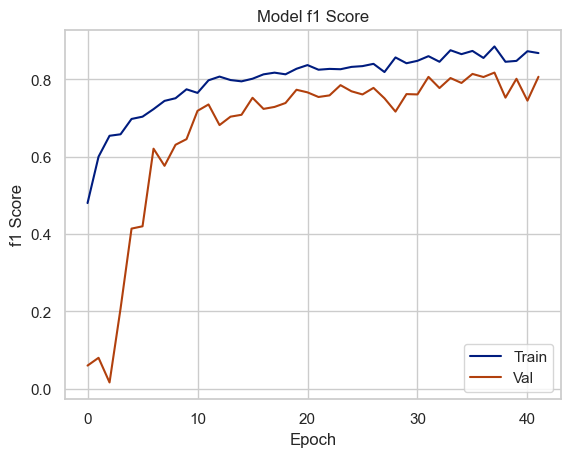

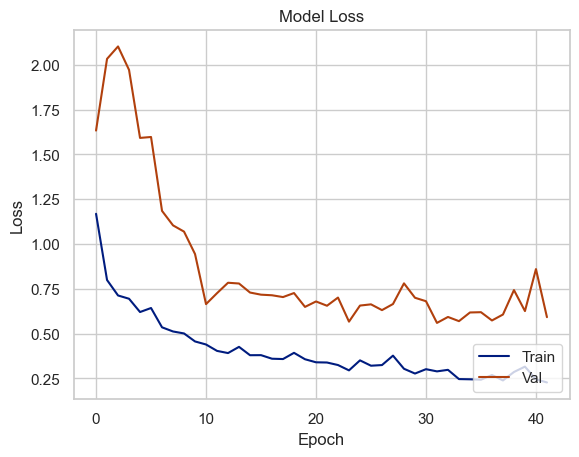

In [ ]:
# Plotting the Model F1 Score
plt.figure()
plt.plot(history_reduced.history['f1_score'], label="Train")
plt.plot(history_reduced.history['val_f1_score'], label="Val")
plt.title('Model f1 Score')
plt.ylabel('f1 Score')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

# Plotting the Model Loss
plt.figure()
plt.plot(history_reduced.history['loss'], label="Train")
plt.plot(history_reduced.history['val_loss'], label="Val")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Finding the Highest Cross Validation Weighted Average f1 Score and Accuracy
print(f"Highest Validation Weighted Average f1 Score: {max(history_reduced.history['val_f1_score'])}")
print(f"Highest Validation Accuracy: {max(history_reduced.history['val_accuracy'])}")

Highest Validation Weighted Average f1 Score: 0.8174011707305908
Highest Validation Accuracy: 0.8154761791229248


In [ ]:
# Evaluating the Model
loss, score, accuracy = model_reduced.evaluate(X_test_neural_reduced, y_test_neural_reduced)
print(f"Test Loss: {loss}, Test Weighted f1 Score: {score}, Test Accuracy: {accuracy}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8000 - f1_score: 0.8099 - loss: 0.5718 
Test Loss: 0.5718227624893188, Test Weighted f1 Score: 0.8098896145820618, Test Accuracy: 0.800000011920929


In [ ]:
# Generating the Prediction Set
y_pred_neural_reduced = model_reduced.predict(X_test_neural_reduced)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [ ]:
# Generating the Class Label Datasets
y_pred_labs_reduced = GetLabels(y_pred_neural_reduced)

In [ ]:
# Generating the Classification Report
report = classification_report(y_test_labs, y_pred_labs_reduced)
print(report)

              precision    recall  f1-score   support

           0       0.58      0.78      0.67        58
           1       0.93      0.80      0.86       262
           2       0.57      0.82      0.67        40

    accuracy                           0.80       360
   macro avg       0.70      0.80      0.73       360
weighted avg       0.84      0.80      0.81       360



**Comments on Reduced Feature Set Neural Network Performance**

Better recall performance than the full feature set on the smaller classes but worse precision. Equal f1 score performance on the largest class compared to the full feature set but with a swap in the relative performance between precision and recall.

# Model Export

In [ ]:
#Saving the Model, Scaler and the Encoders for Model Deployment
"""
joblib.dump(rf_optimum, "employee_performance_rf_model.pkl")
joblib.dump(scaler_reduced, "employee_performance_reduced_scaler.pkl")
joblib.dump(le_empdep, "employee_department_encoder.pkl")
joblib.dump(le_emjbr, "employee_job_role_encoder.pkl")
"""

'\njoblib.dump(rf_optimum, "employee_performance_rf_model.pkl")\njoblib.dump(scaler_reduced, "employee_performance_reduced_scaler.pkl")\njoblib.dump(le_empdep, "employee_department_encoder.pkl")\njoblib.dump(le_emjbr, "employee_job_role_encoder.pkl")\n'

# Analysis Findings and Recommendations

**Best Performing Model**

- The XG Boost Classifier was the best-performing model on the full feature set. This model was used for the feature importance analysis which resulted in the reduced feature set to improve usability.
- The Random Forest Classifier with default intialisation hyperparameters, a random state of 42 and balanced class weights was the best-performing model on the reduced feature set and was exported for for a web-based model deployment.

**Feature Importance for Predicting Employee Performance**

The top three most important features for predicting employee performance were:
- Employee Environment Satisfaction Rating
- Years Since Last Promotion
- Magnitude of the Last Salary Hike

**Departmental Trends**

- Large headcount differences between the three largest and three smallest departments.
- Finance department the worst-performing department
- Environment Satisfaction having a significant impact on performance across almost all departments.
- Work Life Balance also having a noticeable impact on performane across almost all departments.



**Business Recommendations**

- **Trial Flexible Working Arrangements** - Employee Work Life Balance was shown to have a sizeable impact on employee performance across almost all departments. It was also in the top ten most important features for predicting employee performance. It is recommended that INX trial flexible working arrangments such as flexi-hours or work-from-home where possible to help improve employee perceptions of work-life balance.
- **Data Collection on "Low" rated Employees** - The dataset supplied for this analysis was notably absent of any data for employees on the lowest rank of performance ratings. This could be due to speedy retrenchment of said employees. However, this does create an analytical and modelling blindspot where the company is not aware of employees that could potentially have the biggest negative impact on the business through poor performance. It is recommended that in future data is collected on all employees regardless of performance rating level even if retrenchment is imminent.
- **Review of Office Environment** - Employee Environment Satisfaction was the top-ranked factor influencing employee performance. It is recomemnded that a review be conducted into modernising or improving the office environment through measures such as updated decor, layout restructuring or potentially relocation. If this is coupled with the trialling or permanent implementation of flexible working arrangements, it could lead to a far smaller but higher quality office environment than is current in place.
- **Internal Promotions** - Time worked at INX was in the top ten most important factors for predicting employee performance. It is recommended that preference be given to internal promotions over external hires for filling new vacancies where possible.
- **Headcount Rebalancing** - The Finance department was the worst-performing of all the departments. Given how crucial proper financial management is to the survival of a business, it is recommended that a review be conducted into the possible automation with agentic AI agents or augmentation with AI tools such as large language models of certain roles in the three largest departments (Sales, Development and Research and Development) to potentially free up additional budget space for increased headcount in the Finance department. A concurrent review into the automation or AI augmentation of various finance functions should also be conducted. 